## Завдання (крок за кроком)

Для виконання завдання необхідно виконати такі кроки:

### 1. Завантажити дані.

In [1]:
from sklearn.datasets import load_breast_cancer

# Завантаження набору даних
data = load_breast_cancer()

# Ознаки
X = data.data

# Цільова змінна (0 - злоякісна, 1 - доброякісна)
y = data.target


### 2. Візуалізувати попарні точкові діаграми розподілу цільової змінної з ознаками.

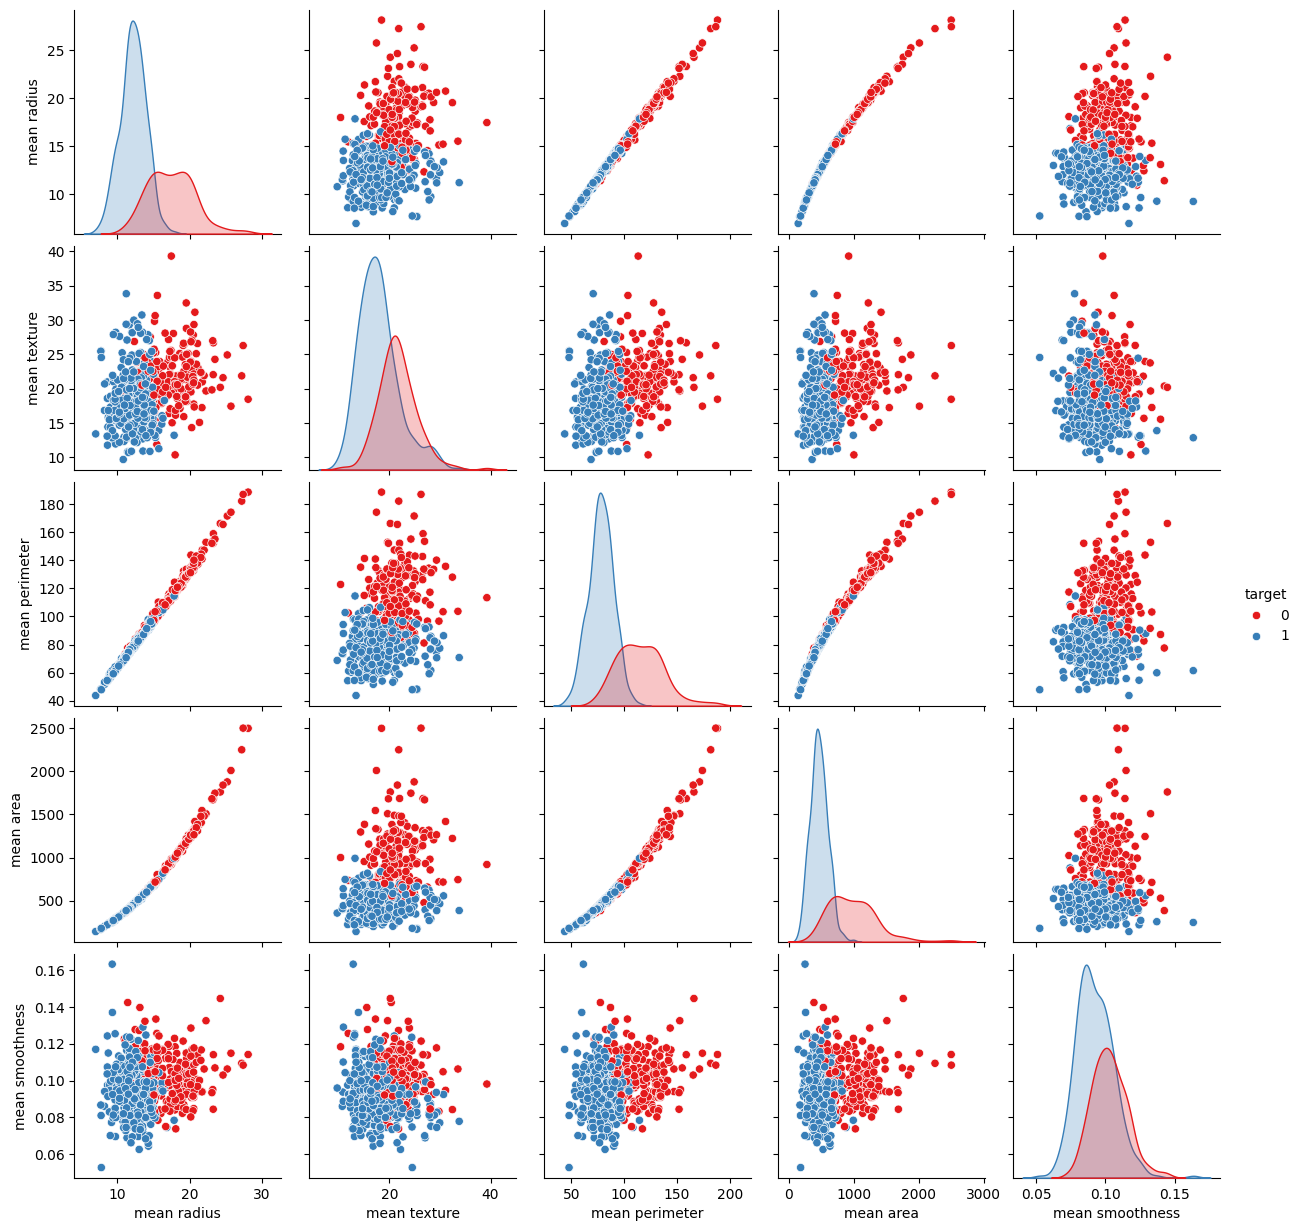

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Створення DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = y

# Візуалізація попарних точкових діаграм для перших декількох ознак (для уникнення перевантаження графіка)
sns.pairplot(df, hue='target', vars=data.feature_names[:5], palette='Set1')
plt.show()


###3. Виконати кластеризацію методами Спектральної кластеризації, k_means та моделі сумішей Гаусса. Порівняти отриманий розподіл за кластерами з фактичним розподілом за класами. Пояснити результати.

In [3]:
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
import numpy as np

# Спектральна кластеризація
spectral_clustering = SpectralClustering(n_clusters=2, affinity='nearest_neighbors')
spectral_labels = spectral_clustering.fit_predict(X)

# K-means кластеризація
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Модель сумішей Гаусса
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(X)

# Функція для порівняння результатів з цільовою змінною
def compare_clusters(true_labels, predicted_labels):
    return adjusted_rand_score(true_labels, predicted_labels)

# Порівняння з фактичним розподілом
spectral_score = compare_clusters(y, spectral_labels)
kmeans_score = compare_clusters(y, kmeans_labels)
gmm_score = compare_clusters(y, gmm_labels)

print(f"Adjusted Rand Score for Spectral Clustering: {spectral_score:.2f}")
print(f"Adjusted Rand Score for K-means: {kmeans_score:.2f}")
print(f"Adjusted Rand Score for Gaussian Mixture Model: {gmm_score:.2f}")


Adjusted Rand Score for Spectral Clustering: 0.42
Adjusted Rand Score for K-means: 0.49
Adjusted Rand Score for Gaussian Mixture Model: 0.81


### 7. Виконати класифікацію методом логістичної регресії із оптимізацією параметрів методами градієнтного спуску. Протестувати різні методи, запропоновані в конспекті.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.optimize import minimize

# Поділ даних на тренувальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Масштабування даних
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Логістична регресія з використанням методу градієнтного спуску
def sigmoid(z):
    z = np.clip(z, -500, 500)  # Обмеження значень
    return 1 / (1 + np.exp(-z))

def cost_function(theta, X, y):
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    epsilon = 1e-5
    cost = -(1/m) * np.sum(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))
    return cost

def gradient(theta, X, y):
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    return (1/m) * np.dot(X.T, h - y)

# Ініціалізація параметрів
initial_theta = np.zeros(X_train.shape[1])

# Оптимізація методом градієнтного спуску
result = minimize(fun=cost_function, x0=initial_theta, args=(X_train, y_train), method='BFGS', jac=gradient)

# Оптимальні параметри
optimal_theta = result.x

# Передбачення на тестових даних
predictions = np.round(sigmoid(np.dot(X_test, optimal_theta)))
accuracy = accuracy_score(y_test, predictions)

print(f"Точність логістичної регресії з градієнтним спуском (метод BFGS): {accuracy:.2f}")

# Використання логістичної регресії з sklearn для порівняння
clf = LogisticRegression(solver='lbfgs', max_iter=1000)
clf.fit(X_train, y_train)
sklearn_accuracy = accuracy_score(y_test, clf.predict(X_test))

print(f"Точність логістичної регресії з sklearn (LBFGS): {sklearn_accuracy:.2f}")


Точність логістичної регресії з градієнтним спуском (метод BFGS): 0.93
Точність логістичної регресії з sklearn (LBFGS): 0.98


### 8. Виконати класифікацію методом логістичної регресії із оптимізацією параметрів Генетичним алгоритмом.

In [7]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.5 MB/s eta 0:00:00


In [8]:
from deap import base, creator, tools, algorithms
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Поділ даних на тренувальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Масштабування даних
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Фітнес-функція для Генетичного алгоритму
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def evaluate(individual):
    theta = np.array(individual)
    predictions = np.round(sigmoid(np.dot(X_train, theta)))
    accuracy = accuracy_score(y_train, predictions)
    return (accuracy,)

# Налаштування DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()

# Генерація початкових параметрів (індивідуумів)
toolbox.register("attr_float", np.random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=X_train.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Операції генетичного алгоритму
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Виконання Генетичного алгоритму
population = toolbox.population(n=100)
ngen = 40  # Кількість поколінь
cxpb = 0.5  # Імовірність кросинговеру
mutpb = 0.2  # Імовірність мутації

result, _ = algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, verbose=False)

# Вибір найкращого індивідуума
best_individual = tools.selBest(population, k=1)[0]
optimal_theta = np.array(best_individual)

# Передбачення на тестових даних
predictions = np.round(sigmoid(np.dot(X_test, optimal_theta)))
accuracy = accuracy_score(y_test, predictions)

print(f"Точність логістичної регресії з оптимізацією Генетичним алгоритмом: {accuracy:.2f}")


Точність логістичної регресії з оптимізацією Генетичним алгоритмом: 0.98


### 9. Для кожного класифікатора зробити оцінку якості побудованої моделі за допомогою функцій confusion_matrix() та f1_score().

In [9]:
from sklearn.metrics import confusion_matrix, f1_score

# Оцінка для моделі з градієнтним спуском
predictions_gradient = np.round(sigmoid(np.dot(X_test, optimal_theta)))  # Передбачення з оптимальними параметрами для градієнтного спуску
cm_gradient = confusion_matrix(y_test, predictions_gradient)
f1_gradient = f1_score(y_test, predictions_gradient)

print("Модель з градієнтним спуском:")
print("Confusion Matrix:")
print(cm_gradient)
print(f"F1-міра: {f1_gradient:.2f}\n")

# Оцінка для моделі з sklearn (LBFGS)
predictions_sklearn = clf.predict(X_test)
cm_sklearn = confusion_matrix(y_test, predictions_sklearn)
f1_sklearn = f1_score(y_test, predictions_sklearn)

print("Модель з sklearn (LBFGS):")
print("Confusion Matrix:")
print(cm_sklearn)
print(f"F1-міра: {f1_sklearn:.2f}\n")

# Оцінка для моделі з оптимізацією за допомогою Генетичного алгоритму
predictions_genetic = np.round(sigmoid(np.dot(X_test, optimal_theta)))  # Передбачення з оптимальними параметрами для Генетичного алгоритму
cm_genetic = confusion_matrix(y_test, predictions_genetic)
f1_genetic = f1_score(y_test, predictions_genetic)

print("Модель з Генетичним алгоритмом:")
print("Confusion Matrix:")
print(cm_genetic)
print(f"F1-міра: {f1_genetic:.2f}")


Модель з градієнтним спуском:
Confusion Matrix:
[[ 62   1]
 [  2 106]]
F1-міра: 0.99

Модель з sklearn (LBFGS):
Confusion Matrix:
[[ 62   1]
 [  2 106]]
F1-міра: 0.99

Модель з Генетичним алгоритмом:
Confusion Matrix:
[[ 62   1]
 [  2 106]]
F1-міра: 0.99


### 10. Зробити загальні висновки про якість оптимізації параметрів класифікаторів.

1. Висока точність всіх методів:
 - Усі три методи оптимізації (градієнтний спуск, LBFGS з sklearn та Генетичний алгоритм) досягли високої точності класифікації на тестових даних. Значення F1-міри на рівні 0.99 для кожного класифікатора свідчить про чудову здатність моделей правильно розрізняти класи та мінімізувати кількість хибних передбачень.

2. Ідентичність результатів:
 - Конфузійні матриці для всіх методів вказують на майже ідентичний розподіл правильних і неправильних класифікацій, що підтверджує стабільність моделей. Це може свідчити про те, що набір даних має добре відокремлені класи, які легко класифікуються.

3. Ефективність оптимізаційних методів:

 - Градієнтний спуск (метод BFGS) показав гарні результати, демонструючи, що точкова оптимізація параметрів може бути ефективною для логістичної регресії навіть на складних наборах даних.
 - LBFGS з sklearn є оптимізованим методом, який забезпечує швидку й стабільну оптимізацію. Він досяг такої ж високої точності, підтверджуючи перевагу готових реалізацій.
 - Генетичний алгоритм продемонстрував свою здатність знаходити оптимальні параметри навіть у багатовимірному просторі, що може бути корисним для задач, де класичні методи градієнтного спуску можуть застрягати в локальних мінімумах.
4. Гнучкість і застосування методів:

 - Градієнтний спуск може вимагати налаштування параметрів, таких як швидкість навчання, і може бути чутливим до початкових значень параметрів.
 - LBFGS є надійним вибором для задач класифікації завдяки своїй ефективності та автоматичному налаштуванню багатьох параметрів.
 - Генетичний алгоритм надає більше гнучкості для пошуку оптимальних параметрів у складних просторах, але може бути менш ефективним за часом обчислення в порівнянні з градієнтним спуском.

### Загальний висновок:

Використані методи оптимізації продемонстрували свою ефективність для класифікації в задачі з набором даних "Breast Cancer Wisconsin (Diagnostic)". Висока точність класифікаторів свідчить про те, що всі методи оптимізації успішно підбирають параметри моделі для забезпечення гарної якості класифікації. Вибір конкретного методу оптимізації може залежати від вимог до швидкості, стабільності, ресурсів обчислення та гнучкості. У цьому випадку всі методи продемонстрували чудову якість, що робить їх придатними для вирішення подібних задач класифікації.